In [32]:
import requests
import random
import pandas as pd 
from tqdm import tqdm
import json 

import ast

# Tools

import folium
from shapely.geometry import Polygon
import numpy as np
import geojson
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely.wkt
from haversine import haversine, Unit
import time
from pyproj import Geod

from shapely import wkt
from geopandas import datasets, GeoDataFrame, read_file, points_from_xy
from geopandas.tools import overlay
from geopandas.tools import sjoin

from folium.plugins import MeasureControl
from folium.plugins import MarkerCluster

import os
from dotenv import load_dotenv

load_dotenv()

True

In [33]:
YOUR_API_KEY = os.getenv('API_KEY')
YOUR_API_KEY

'DmGXxjVgjYt4B3b8JOXGG6LLqVP3koaMtAcb7pu-epo'

In [34]:
df_map = pd.read_csv('DATASET_FINAL.csv')

In [35]:
df_map.head(2)

,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,Precio,Estado,Dir2,Full_Address,Coords
0,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,GASOLINA CORRIENTE OXIGENADA,9860,A,AVENIDA CARRERA 7 No. 123A-48,"AVENIDA CARRERA 7 No. 123A-48, Bogota d.c., C...","(4.69921, -74.02878)"
1,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,BIODIESEL EXTRA,9780,A,AVENIDA CARRERA 7 No. 123A-48,"AVENIDA CARRERA 7 No. 123A-48, Bogota d.c., C...","(4.69921, -74.02878)"


In [36]:
df_map = df_map.drop_duplicates(subset=['Nombre_comercial','Bandera','Producto'])

In [37]:
len(df_map)

940

In [38]:
df_map['Coords'].value_counts()

('NA', 'NA')            20
(4.61872, -74.07497)     6
(4.68947, -74.06588)     6
(4.60302, -74.14303)     5
(4.4976, -74.10764)      5
                        ..
(4.62139, -74.18436)     1
(4.75523, -74.06481)     1
(4.59662, -74.17924)     1
(4.70551, -74.10576)     1
(4.49828, -74.10745)     1
Name: Coords, Length: 366, dtype: int64

In [39]:
df_map[df_map['Coords']=="('NA', 'NA')"]['Direccion'].unique()

array(['Avenida Carrera 30 # 2 - 38', 'CRA 17 # 50-42',
       'CALLE 80 # 24-30', 'Carrera 73 # 36A - 55 Sur',
       'Calle 13 # 38 - 25', 'Calle 19 # 33 - 68', 'Carrera 7 # 84 - 91',
       'CR 63 NO. 57 G - 74 Sur'], dtype=object)

In [40]:
df_map.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 940 entries, 0 to 1365
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Periodo              940 non-null    int64 
 1   Mes                  940 non-null    int64 
 2   Codigo_departamento  940 non-null    int64 
 3   Departamento         940 non-null    object
 4   Codigo_municipio     940 non-null    int64 
 5   Municipio            940 non-null    object
 6   Nombre_comercial     940 non-null    object
 7   Bandera              940 non-null    object
 8   Direccion            940 non-null    object
 9   Producto             940 non-null    object
 10  Precio               940 non-null    int64 
 11  Estado               940 non-null    object
 12  Dir2                 940 non-null    object
 13  Full_Address         940 non-null    object
 14  Coords               940 non-null    object
dtypes: int64(5), object(10)
memory usage: 117.5+ KB


In [41]:
df_map['Coords'][0]

'(4.69921, -74.02878)'

In [42]:
float(df_map['Coords'][0].replace('(','').replace(')','').split(',')[0]) # Lat

4.69921

In [43]:
float(df_map['Coords'][0].replace('(','').replace(')','').split(',')[1].strip()) # Longitud

-74.02878

In [44]:
df_map['LAT'] = df_map['Coords'].apply(lambda x : float(x.replace('(','').replace(')','').split(',')[0]) if x !=  "('NA', 'NA')"  else 'Empty')
df_map['LNG'] = df_map['Coords'].apply(lambda x : float(x.replace('(','').replace(')','').split(',')[1]) if x !=  "('NA', 'NA')"  else 'Empty')

In [45]:
df_map['LAT'].value_counts()

Empty      20
4.61872     6
4.68947     6
4.5894      6
4.4976      5
           ..
4.59945     1
4.59662     1
4.70551     1
4.68173     1
4.49828     1
Name: LAT, Length: 361, dtype: int64

In [46]:
df_map['LNG'].value_counts()

Empty        20
-74.07497     6
-74.06588     6
-74.08027     6
-74.10764     5
             ..
-74.17924     1
-74.10745     1
-74.08485     1
-74.09248     1
-74.18436     1
Name: LNG, Length: 363, dtype: int64

# Funciones a usar 

In [47]:
def GetLatLon2(Address,YOUR_API_KEY): 

    url2_geocode  = f'https://geocode.search.hereapi.com/v1/geocode?q={Address}&apiKey='+YOUR_API_KEY
    
    try:
        response = requests.get(url2_geocode).json()
        CleanAddress = response['items'][0]['title'].upper()
        LAT = response['items'][0]['position']['lat']
        LON = response['items'][0]['position']['lng']
        results = [CleanAddress,round(LAT,7),round(LON,7)]
    except:
        results = ['NotFound','NA','NA']
    return results

def GetLatLon2_google(Address,YOUR_API_KEY): 

    api_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={Address}&key={YOUR_API_KEY}'
    try:
        j = requests.get(api_url).json()
        CleanAddress = str(j['results'][0]['formatted_address']).upper()
        LAT = j['results'][0]['geometry']['location']['lat']
        LON = j['results'][0]['geometry']['location']['lng']
        results = [CleanAddress,round(LAT,7),round(LON,7)]
    except:
        results = ['NotFound','NA','NA']
    return results,j 


def cal_dist(geo_source,point2,unit):
    
    
    if unit == 'Km':
        distance = haversine(geo_source, point2,Unit.KILOMETERS)
    elif unit == 'm':
        distance = haversine(geo_source, point2,Unit.METERS)
    elif unit == 'miles':
        distance = haversine(geo_source, point2,Unit.MILES)
    
    return round(distance,2)


def distance_estac(geo_source,df,radio,unit):
    
    
    distancia = []
    source = []


    for i in tqdm(range(len(df)),colour = 'green'):
        distancia.append(cal_dist(geo_source,df['POINT'][i],unit))
        source.append(geo_source)

    new_df = df.copy()
    new_df['SOURCE'] = source
    new_df['DISTANCE'] = distancia
    new_df = new_df[new_df['DISTANCE']<=radio]
    new_df = new_df.reset_index()
    new_df = new_df.drop(columns ='index')
    return new_df.sort_values(by='DISTANCE',ascending=True)

def transform_df_map(df):
    

    coordenadas = []

    for i in range(len(df)):
        
        try :
            
            coord = float(df['LAT'][i]),float(df['LNG'][i])
            coordenadas.append(coord)

        except :
            
            coordenadas.append('EMPTY')
            
    df['POINT'] = coordenadas
    df = df[df['POINT']!='EMPTY']
    df = df.reset_index()
    df = df.drop(columns = 'index')
    new_df = df.copy()
    
    return new_df

# Paso a Paso de la App

1. Filtrar la ciudad
2. Ingresar la central location
3. Configurar el radio y la unidad de medida
4. Calcular la distancia


# Filtrar ciudad

In [48]:
cities = list(df_map['Municipio'].unique())
cities

['BOGOTA  D.C.']

In [85]:
df_city = df_map[df_map['Municipio']==cities[0]]
df_city.reset_index(inplace=True)
df_city.drop(columns='index',inplace=True)
df_city.to_csv('DF_STATIONS.CSV',index = False)

In [50]:
central_location = 'CC Multiplaza, Bogota'
central_location = central_location.replace('#','No')
R = GetLatLon2(central_location, YOUR_API_KEY)

In [51]:
geo_source = R[1], R[2]
geo_source

(4.65226, -74.12695)

In [52]:
radio = 1
unit = 'Km'

In [54]:
df_city = transform_df_map(df_city)
df_city.head(2)

,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,Precio,Estado,Dir2,Full_Address,Coords,LAT,LNG,POINT
0,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,GASOLINA CORRIENTE OXIGENADA,9860,A,AVENIDA CARRERA 7 No. 123A-48,"AVENIDA CARRERA 7 No. 123A-48, Bogota d.c., C...","(4.69921, -74.02878)",4.69921,-74.02878,"(4.69921, -74.02878)"
1,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,BIODIESEL EXTRA,9780,A,AVENIDA CARRERA 7 No. 123A-48,"AVENIDA CARRERA 7 No. 123A-48, Bogota d.c., C...","(4.69921, -74.02878)",4.69921,-74.02878,"(4.69921, -74.02878)"


In [57]:
results = distance_estac(geo_source,df_city,radio,unit)
results.reset_index(inplace =  True)
results.drop(columns= 'index' , inplace = True)

100%|██████████| 920/920 [00:00<00:00, 129789.10it/s]


In [58]:
results['Nombre_comercial'].unique()

array(['EDS ESSO INDUSTRIAL BOYACA',
       'ESTACION DE SERVICIO MILENIUM GAS CALLE 13',
       'ESTACION DE SERVICIO FERROCARRIL',
       'ESTACION DE SERVICIO TERPEL VILLA ALZACIA',
       'ESTACION DE SERVICIO VILLA ALSACIA'], dtype=object)

In [59]:
results['Producto'].unique()

array(['GASOLINA CORRIENTE OXIGENADA', 'BIODIESEL EXTRA',
       'GASOLINA EXTRA OXIGENADA'], dtype=object)

In [60]:
type(results)

pandas.core.frame.DataFrame

In [62]:
gdf_results = GeoDataFrame(results,
                          geometry =  points_from_xy(results.LNG,results.LAT))

In [64]:
gdf_results.head(2)

,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,...,Estado,Dir2,Full_Address,Coords,LAT,LNG,POINT,SOURCE,DISTANCE,geometry
0,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,EDS ESSO INDUSTRIAL BOYACA,MOBIL,CARRERA 71 No. 19-05,GASOLINA CORRIENTE OXIGENADA,...,A,CARRERA 71 No. 19-05,"CARRERA 71 No. 19-05, Bogota d.c., Colombia","(4.65127, -74.1234)",4.65127,-74.1234,"(4.65127, -74.1234)","(4.65226, -74.12695)",0.41,POINT (-74.12340 4.65127)
1,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,EDS ESSO INDUSTRIAL BOYACA,MOBIL,CARRERA 71 No. 19-05,BIODIESEL EXTRA,...,A,CARRERA 71 No. 19-05,"CARRERA 71 No. 19-05, Bogota d.c., Colombia","(4.65127, -74.1234)",4.65127,-74.1234,"(4.65127, -74.1234)","(4.65226, -74.12695)",0.41,POINT (-74.12340 4.65127)


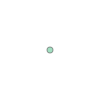

In [65]:
gdf_results['geometry'][0]

In [66]:
oil = list(gdf_results['Producto'].unique())
oil

['GASOLINA CORRIENTE OXIGENADA', 'BIODIESEL EXTRA', 'GASOLINA EXTRA OXIGENADA']

In [79]:
gdf_results_2 = gdf_results[gdf_results['Producto']==oil[2]]
gdf_results_2.reset_index(inplace =  True)
gdf_results_2.drop(columns= 'index' , inplace = True)

/home/vscode/miniforge3/lib/python3.10/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [80]:
gdf_results_2.columns

Index(['Periodo', 'Mes', 'Codigo_departamento', 'Departamento',
       'Codigo_municipio', 'Municipio', 'Nombre_comercial', 'Bandera',
       'Direccion', 'Producto', 'Precio', 'Estado', 'Dir2', 'Full_Address',
       'Coords', 'LAT', 'LNG', 'POINT', 'SOURCE', 'DISTANCE', 'geometry'],
      dtype='object')

In [81]:
gdf_results_2['Precio'].min()

16400

In [82]:
gdf_results_2['Precio'].max()

17130

In [77]:
def marker_rest(df,mapa,unit,oil,icono):
    
    df = df[df['Producto']==oil]
    df = df.reset_index()
    df = df.drop(columns = 'index')
    
    for i in range(len(df)):
        
        if df['Precio'][i]==df['Precio'].min():
        
            html =  f"""<b>MARCA:</b> {df.Bandera[i]} <br>
                    <b>NAME:</b> {df.Nombre_comercial[i]} <br>
                    <b>PRODUCTO:</b> {df.Producto[i]} <br>
                    <b>PRECIO:</b> {df.Precio[i]} <br>
                    <b>DISTANCE:</b> {round(df.DISTANCE[i],2)}<br>
                    <b>DIRECCION:</b> {df.Direccion[i]}<br>
                    <b>UNIT:</b> {unit}<br>"""
            iframe = folium.IFrame(html,figsize=(6, 3))
            popup = folium.Popup(iframe)
            



            folium.Marker(location=[float(df['LAT'][i]),float(df['LNG'][i])],
                               icon=folium.Icon(color='darkgreen', icon_color='white',
                               icon=icono, prefix='glyphicon'),
                               popup = popup).add_to(mapa)
        
        elif df['Precio'][i]==df['Precio'].max():
        
            html =  f"""<b>MARCA:</b> {df.Bandera[i]} <br>
                    <b>NAME:</b> {df.Nombre_comercial[i]} <br>
                    <b>PRODUCTO:</b> {df.Producto[i]} <br>
                    <b>PRECIO:</b> {df.Precio[i]} <br>
                    <b>DISTANCE:</b> {round(df.DISTANCE[i],2)}<br>
                    <b>DIRECCION:</b> {df.Direccion[i]}<br>
                    <b>UNIT:</b> {unit}<br>"""
            iframe = folium.IFrame(html,figsize=(6, 3))
            popup = folium.Popup(iframe)



            folium.Marker(location=[float(df['LAT'][i]),float(df['LNG'][i])],
                               icon=folium.Icon(color='darkred', icon_color='white',
                               icon=icono, prefix='glyphicon'),
                               popup =popup).add_to(mapa)
        else :
            html =  f"""<b>MARCA:</b> {df.Bandera[i]} <br>
                    <b>NAME:</b> {df.Nombre_comercial[i]} <br>
                    <b>PRODUCTO:</b> {df.Producto[i]} <br>
                    <b>PRECIO:</b> {df.Precio[i]} <br>
                    <b>DISTANCE:</b> {round(df.DISTANCE[i],2)}<br>
                    <b>DIRECCION:</b> {df.Direccion[i]}<br>
                    <b>UNIT:</b> {unit}<br>"""
            iframe = folium.IFrame(html,figsize=(6, 3))
            popup = folium.Popup(iframe)



            folium.Marker(location=[float(df['LAT'][i]),float(df['LNG'][i])],
                               icon=folium.Icon(color='orange', icon_color='white',
                               icon=icono, prefix='glyphicon'),
                               popup =popup).add_to(mapa)
                           
    return

# Show Map

In [84]:
m = folium.Map([geo_source[0],geo_source[1]], zoom_start= 15)

folium.Circle(
    radius = int(radio)*1000,
    location = [geo_source[0],geo_source[1]],
    color = 'green',
    fill = 'green'

).add_to(m)

folium.Marker(

            location = [geo_source[0],geo_source[1]],
            icon =  folium.Icon(color='black',icon_color='white',
            icon = "home",prefix = 'glyphicon'),
            popup = "<b>Centroid</b>"
).add_to(m)
marker_rest(gdf_results_2,m,unit,oil[2],'usd')
m